# Testing Catboost on the titanic dataset
I've heard that catboost was doing quite well on various benchmarks and that it came with built-in mechanisms to process categorical and text variables. I wanted to put it to the test.

Many of the other algorithms I've used (e.g. logistic regression, but even xgboost, my current go-to) require quite some preprocessing and a fair bit of data exploration. What I find very interesting here is that we could speed up the work greatly and get at least comparable results, if not same / better according to certain benchmarks. There can be a lot of value there, as time saved can be used to do other projects, or have a fast prototype / first version and trigger continuous improvement. Having a first working version has proved to be key in my experience, as it gives all stakeholders of a project an idea of the kind of output they will get, leading to a faster overall project integration as services interacting with the model can be built with real data, and the project can fail fast if it seems overall it won't work. 

## Methodology
I will:
- Start by creating a class that can support the testing 
- Test catboost without any preprocessing on the variables (e.g. no missing value imputing on any variable, no feature building by extracting the title fron the Name...)
- Build a few features and see it if / how it changes the performance

My past experience with this dataset is that building features doesn't help that much. My best result is actually using xgboost with various default tools I've built at work without any tuning to the data, almost like running an auto-ml software. Hence I am curious to see how catboost performs without any feature engineering, with a little bit of it, and with heavier engineering.

### Data import
Note: I'm running this on Kaggle.

In [1]:
import pandas as pd
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Define the model class
I will here define a class that can take the training / prediction data as an input and format it for catboost.
We will need to:
- Set text and categorical variables
- Drop variables that need to be dropped
- Replace the missing values for categorical and text variables
- Follow the sklearn api with fit and predict methods


In [2]:
import catboost
from catboost import Pool, cv
import numpy as np 
from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from matplotlib import pyplot as plt
from skopt.utils import use_named_args
from skopt import gp_minimize
import shap


class CatboostModel:
    def __init__(self, **catboost_args):
        """
        Initializes the catboost model. Any arguments passed as keyword arguments will be passed down to the CatBoostClassifier."""
        self.model = self.set_model(**catboost_args)
        self.non_numeric = None
        self.drop_list = None
        self.pool = None
        self.columns = None
    
    @staticmethod
    def set_model(**catboost_args):
        if "loss_function" not in catboost_args:
            catboost_args["loss_function"] = "Logloss"
        if "eval_metric" not in catboost_args:
            catboost_args["eval_metric"] = "Precision"
        return catboost.CatBoostClassifier(**catboost_args)
    
    def fit(self, 
            x: pd.DataFrame, 
            label: str = "Survived",
            cat_features: list = None,
            text_features: list = None,
            drop_list: list = None,
            evaluate: bool = True,
            **cv_params
           ) -> None:
        """
        Fits the model to the input data x and keeps that model trained. It will also perform
        crossvalidation on the training data to have an evaluation of accuracy on training.
        
        Args:
            x: training data
            label: string, column to use as label
            cat_features: str or list, features that are to be treated as categorical
            text_features: str or list, features that are to be treated as text
            drop_list: list of variables to drop. Note that PassengerId will not be used 
                as a feature and set as index for the pandas DataFrame.
        """
        # Set the experiment: x_train, y_train, categorical features, text features, drop columns
        self.set_experiment(
            x=x,
            label=label,
            cat_features=cat_features,
            text_features=text_features,
            drop_list=drop_list)

        self.model.fit(
            self.x_train, 
            y=self.y_train,
            cat_features=self.cat_features,
            text_features=self.text_features,
            logging_level="Silent")
        
        self.latest_scores = self.evaluate(**cv_params)
        print(f"cross validation scores with catboost: \n{self.latest_scores.loc[len(self.latest_scores) - 1, :]}")
        print(f"parameters: {self.model.get_params()}")
        
    def set_experiment(
            self, 
            x: pd.DataFrame, 
            label: str = "Survived",
            cat_features: list = None,
            text_features: list = None,
            drop_list: list = None
           ) -> None:
        """
        Sets x_train, y_train, text_features, cat_features
        
        Args:
            x: training data
            label: string, column to use as label
            cat_features: str or list, features that are to be treated as categorical
            text_features: str or list, features that are to be treated as text
            drop_list: list of variables to drop. Note that PassengerId will not be used 
                as a feature and set as index for the pandas DataFrame.
        """
        # Set index
        x = x.set_index("PassengerId")
        # Drop non useful features
        self.drop_list = self.set_drop_list(drop_list)
        x = x.drop(self.drop_list, axis=1, errors="ignore")  # Ignore if missing column to drop
        # Set text and categorical feature
        self.text_features = self.set_text_features(x, text_features)
        self.cat_features = self.set_categorical_features(x, cat_features, *self.text_features)
        self.non_numeric = self.text_features + self.cat_features
        # Fill missing values
        x = self.set_missing_values(x, self.non_numeric)
        # Split training and label
        self.x_train, self.y_train = self.set_train_and_label(x, label)
        # Record columns for importance
        self.columns = self.x_train.columns
        # Set a pool for evaluation
        self.pool = Pool(
                 self.x_train, 
                 label=self.y_train,
                 cat_features=self.cat_features,
                 text_features=self.text_features)

    def evaluate(self, **params):   
        scores = catboost.cv(
                      self.pool,
                      self.model.get_params(), 
                      logging_level="Silent",
                      plot=False,
                      **params)
        return scores   
    
    def tune_model(self,
                   x: pd.DataFrame, 
                   space: list,
                   label: str = "Survived",
                   cat_features: list = None,
                   text_features: list = None,
                   drop_list: list = None,
                   early_stopping_rounds=20,
                   n_calls=10, 
                   n_random_starts=2,
                   n_jobs=-1,
                   **eval_params
                  ):
        
        self.set_experiment(
            x=x,
            label=label,
            cat_features=cat_features,
            text_features=text_features,
            drop_list=drop_list)
        
        @use_named_args(param_space)
        def objective(**params):
            self.model.set_params(**params)
            scores = self.evaluate(
                **eval_params)
            test_scores = scores.iloc[:, 2]
            best_metric = test_scores.max()
            return 1 - best_metric
        
        res_gp = gp_minimize(objective, space, n_calls=n_calls, n_random_starts=n_random_starts, n_jobs=n_jobs)
        best_values = res_gp.x
        optimal_values = dict(zip([param.name for param in space], best_values))
        best_score = res_gp.fun
        self.best_score = best_score
        self.res_gp = res_gp
        
        print('optimal_parameters: {}\noptimal score: {}'.format(optimal_values, best_score))
        print('updating model with optimal values')
        params = self.model.get_params()
        params.update(optimal_values)
        self.model = self.set_model(**params)
        return optimal_values
        
    def predict(self,
               x: pd.DataFrame) -> pd.DataFrame:
        """
        Generates predictions using the fitted model. Returns a pandas DataFrame formatted as Kaggle
        needs it for a submission: 2 columns, "PassengerId" and "Survived", the latter being the prediction.
        """
        # Drop non useful features and set PassengerId as index
        x = x.set_index("PassengerId")
        # Drop non useful features
        x = x.drop(self.drop_list, axis=1, errors="ignore")  # Ignore if missing column to drop
        # Fill missing values
        x = self.set_missing_values(x, self.non_numeric)
        # Get predictions
        x["Survived"]  = model.model.predict(x)
        # Return formatted predictions
        x = x.reset_index()
        return x.loc[:, ["PassengerId", "Survived"]]
        
    
    @staticmethod
    def set_drop_list(drop_list: list):
        """Sets the list of variables to drop."""
        if drop_list is None:
            return []
        elif isinstance(drop_list, str):
            return [drop_list]
        elif isinstance(drop_list, list):
            return drop_list
        else:
            raise Exception(f"drop_list must be a list. Can also be a str or None, "
                            "which will be formatted to a list. Provided: {type(drop_list)}")
        
    
    @staticmethod
    def set_missing_values(x: pd.DataFrame, non_numeric: list) -> pd.DataFrame:
        """Replaces missing values for non numeric variables to NaN"""
        x.loc[:, non_numeric] = x.loc[:, non_numeric].fillna("NaN")
        return x
    
    @staticmethod
    def set_train_and_label(x: pd.DataFrame, label: str) -> tuple:
        """Returns a tuple:
        (training data, corresponding labels)
        """
        return x.drop(label, axis=1), x.loc[:, label]
        
    @staticmethod
    def set_categorical_features(x: pd.DataFrame, cat_features:list, *ignore) -> list:
        """Returns a list of categorical columns, automatically detected with pandas."""
        cols = CatboostModel._set_columns(x.columns, ignore)
        print(cols)
        if isinstance(cat_features, str):
            return [cat_features]
        elif isinstance(cat_features, list):
            return cat_features
        else:
            return [i for i in cols if (is_categorical_dtype(x.loc[:, i]) or is_string_dtype(x.loc[:, i]))]

    @staticmethod
    def set_text_features(x:pd.DataFrame, text_features: list):
        """Sets text features."""
        if isinstance(text_features, list):
            return text_features
        elif isinstance(text_features, str):
            return [text_features]
        else:
            return []
        
    @staticmethod
    def _set_columns(columns: list, ignore: list):
        """Sets columns to use for the various set_ methods, e,g, in set_categorical_features
        we don't want to include text features as they would be picked up as categories."""
        return [i for i in columns if i not in ignore]
    
    def get_feature_importance(self) -> list:
        """Returns a list of feature importanes."""
        return self.model.get_feature_importance(self.pool)
    
    def inspect_model(self) -> None:
        # Plot feature importance (always available)
        self.plot_importance()
        # feature interactions and shap values are not available when using text features
        if not self.text_features:
            self.plot_feature_interactions()
            self.plot_shap_values()    
    
    def plot_importance(self) -> None:
        """
        Catboost will only give the id of the feature importance. Hence we map that id back to the column name 
        and print the importance value.
        """
        # Get feature importance
        importances = self.get_feature_importance()
        columns = self.columns
        # Build series, sort values and plot
        pd.Series(importances, index=columns).sort_values().plot.barh()
        # Set additional plotting options
        plt.xlabel('Importance Percentage')
        plt.title('How much do each feature contribute to the prediction?')
        # Display the actual value (rounded)
        self.set_plot_text(sorted(importances))
        # Show plot
        plt.show()
        
    def plot_feature_interactions(self) -> None:
        interactions = self.model.get_feature_importance(model.pool, fstr_type=catboost.EFstrType.Interaction, prettified=True)
        feature_interaction = pd.DataFrame()
        feature_interaction["Features"] = interactions.loc[:, "First Feature Index"].apply(lambda x: model.columns[x]).astype(str) + \
                                          " \ " + \
                                          interactions.loc[:, "Second Feature Index"].apply(lambda x: model.columns[x]).astype(str)
        feature_interaction["Interaction value"] = interactions.loc[:, "Interaction"].round(1)
        feature_interaction.set_index("Features", inplace=True)
        feature_interaction.plot(kind='barh', figsize=(18, 10), fontsize=12, color='b')
        # Set additional plotting options
        plt.xlabel('Importance Percentage')
        plt.title('How much do each feature contribute to the prediction?')
        # Display the actual value (rounded)
        self.set_plot_text(feature_interaction.loc[:, "Interaction value"].to_list())
        plt.show()
        
    def plot_shap_values(self) -> None:
        shap_values = self.model.get_feature_importance(model.pool, fstr_type=catboost.EFstrType.ShapValues)
        shap.initjs()
        shap.summary_plot(shap_values[:, :-1], self.x_train, feature_names=self.columns.tolist())
    
    @staticmethod
    def set_plot_text(value_list: list) -> None:
        for index, value in enumerate(value_list):
            plt.text(value, index, str(round(value, 1)))
        

### Fit and evaluate
Text features only work with GPU, so we'll set the task_type to GPU and activate GPU acceleration on the kaggle notebook. Other than the text feature, the categorical and numeric variables are auto detected using pandas api.types.

In [3]:
%%time
model = CatboostModel(task_type="GPU")
model.fit(train, text_features="Name")

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
cross validation scores with catboost: 
iterations              999.000000
test-Precision-mean       0.790955
test-Precision-std        0.019549
train-Precision-mean      0.957403
train-Precision-std       0.014054
test-Logloss-mean         0.421221
test-Logloss-std          0.028667
train-Logloss-mean        0.210541
train-Logloss-std         0.015109
Name: 999, dtype: float64
parameters: {'task_type': 'GPU', 'eval_metric': 'Precision', 'loss_function': 'Logloss'}
CPU times: user 4min 20s, sys: 1min 3s, total: 5min 24s
Wall time: 4min 34s


test precision is at 78.5%. I've ran this several times and the result is quite stable, although I got up to 81%. This is in line with the other algorithms I tried.

In [4]:
pred = model.predict(test)
pred.to_csv('submission_with_text.csv', index=False)

This yielded a score of 0.75598. Not bad for the amount of work and given that most solutions score 0.775. In real life, we may not even consider this gap as statistically significant (as there are very few samples in the test data used for scoring). 
Lets tweak this a little.

**Without text features**

In [5]:
%%time
model = CatboostModel(task_type="CPU")  
model.fit(train)
pred = model.predict(test)
pred.to_csv('submission_without_text.csv', index=False)

['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
cross validation scores with catboost: 
iterations              999.000000
test-Precision-mean       0.790477
test-Precision-std        0.025778
train-Precision-mean      0.990825
train-Precision-std       0.000073
test-Logloss-mean         0.451014
test-Logloss-std          0.042213
train-Logloss-mean        0.126768
train-Logloss-std         0.007700
Name: 999, dtype: float64
parameters: {'task_type': 'CPU', 'eval_metric': 'Precision', 'loss_function': 'Logloss'}
CPU times: user 26 s, sys: 5.76 s, total: 31.7 s
Wall time: 1min 21s


**NaN processing**

Catboost automatically transforms the NaNs to the minimum in the distribution. For a variable like Age, this is probably increasing significantly the chances of positive classification, as younger people had more chances of survival. We do not want this. As Catboost is a tree based model, we can give an impossible value for it to know it is something different. 

Here, Age is the only numeric variable that has missing values, and we are replacing them by "NaN" in the other variables. However, -1000 would be an impossible and out of distribution for all these variables, so we can just replace all missing values by -1000.

In [6]:
%%time
model = CatboostModel() 
model.fit(train.fillna(-1000))
pred = model.predict(test.fillna(-1000))
pred.to_csv('submission_without_text_fillna.csv', index=False)

['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
cross validation scores with catboost: 
iterations              999.000000
test-Precision-mean       0.790477
test-Precision-std        0.025778
train-Precision-mean      0.990825
train-Precision-std       0.000073
test-Logloss-mean         0.451014
test-Logloss-std          0.042213
train-Logloss-mean        0.126768
train-Logloss-std         0.007700
Name: 999, dtype: float64
parameters: {'eval_metric': 'Precision', 'loss_function': 'Logloss'}
CPU times: user 25.3 s, sys: 5.81 s, total: 31.1 s
Wall time: 1min 19s


We can't see any improvements in that report. This is a relatively good sign, if it doesn't change much then we can either leave the default value, or fillna with something completely impossible for every column and have a good prototype.

**Drop some columns**

Some columns as is may be only adding noise. It would be the case for Cabin (too many nulls), Embarked (why would the port matter), Name (useless unprocessed), Ticket (these are just ticket ids). We may this way reduce overfitting.

In [7]:
%%time
model = CatboostModel() 
model.fit(train.fillna(-1000).drop(["Cabin", "Embarked", "Name", "Ticket"], axis=1))
pred = model.predict(test.fillna(-1000).drop(["Cabin", "Embarked", "Name", "Ticket"], axis=1))
pred.to_csv('submission_without_text_fillna_cols_dropped.csv', index=False)

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
cross validation scores with catboost: 
iterations              999.000000
test-Precision-mean       0.790004
test-Precision-std        0.017767
train-Precision-mean      0.987865
train-Precision-std       0.005165
test-Logloss-mean         0.462667
test-Logloss-std          0.049408
train-Logloss-mean        0.118860
train-Logloss-std         0.008158
Name: 999, dtype: float64
parameters: {'eval_metric': 'Precision', 'loss_function': 'Logloss'}
CPU times: user 8.64 s, sys: 3.21 s, total: 11.9 s
Wall time: 1min 5s


### Adding some features
Lets build a few features by:
- Parsing the name
- Calulating the family size
- See if the family is traveling with a [0 - 1] year old, [1 - 15] or [15 - 21] (this split is based on age vs survived where I could see 4 groups)
- We could bin the fare (we'll test with and without) as my past experience with this dataset is that this variable lead to overfitting

In [8]:
# Define preprocessing functions
import re


def get_title(name: str) -> str:
    return re.search("([A-Za-z]+)\.", name).group(1)
    
    
def test_get_title():
    assert get_title("Braund, Mr. Owen Harris") == "Mr"
    assert get_title("Heikkinen, Miss. Laina") == "Miss"


def get_family_size(df: pd.DataFrame) -> pd.Series:
    return df.loc[:, "SibSp"] + df.loc[:, "Parch"]


def get_last_name(name: str) -> str:
    return re.search("^(.+?),", name).group(1).split(",")[0]


def test_get_last_name():
    assert get_last_name("Braund, Mr. Owen Harris") == "Braund"
    assert get_last_name("Heikkinen, Miss. Laina") == "Heikkinen"
    

def get_family_id(df: pd.DataFrame) -> pd.Series:
    df = df.copy()
    df["last_name"] = df.loc[:, "Name"].apply(get_last_name)
    df["family_id"] = df.loc[:, "last_name"].astype(str) + df.loc[:, "Embarked"].astype(str)
    return df.loc[:, "family_id"]


def get_children_age_count(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["family_id"] = get_family_id(df)
    df_origin = df.copy()
    df["youngest_age_inf_1"] = df.loc[:, "Age"].between(0, 1)
    df["youngest_age_1_15"] = df.loc[:, "Age"].between(1, 15)
    df["youngest_age_15_21"] = df.loc[:, "Age"].between(15, 21)
    tmp1 = df.loc[:, ["family_id", "youngest_age_inf_1"]].groupby("family_id").sum()
    tmp2 = df.loc[:, ["family_id", "youngest_age_1_15"]].groupby("family_id").sum()
    tmp3 = df.loc[:, ["family_id", "youngest_age_15_21"]].groupby("family_id").sum()
    df_final = df_origin.join(tmp1, on="family_id").join(tmp2, on="family_id").join(tmp3, on="family_id")
    return df_final.drop("family_id", axis=1)


test_get_title()
test_get_last_name()

**Let's put all of that together in a preprocess function**

In [9]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["title"] = df.loc[:, "Name"].apply(get_title)
    df = get_children_age_count(df)
    df["family_size"] = get_family_size(df)
    return df

preprocess(train).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,youngest_age_inf_1,youngest_age_1_15,youngest_age_15_21,family_size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0.0,0.0,0.0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,0.0,0.0,0.0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0.0,0.0,0.0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,0.0,0.0,0.0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0.0,0.0,0.0,0


**Build the model and export results**

In [10]:
%%time
model = CatboostModel() 
model.fit(preprocess(train).fillna(-1000).drop(["Cabin", "Embarked", "Name", "Ticket"], axis=1))
pred = model.predict(preprocess(test).fillna(-1000).drop(["Cabin", "Embarked", "Name", "Ticket"], axis=1))

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'title', 'youngest_age_inf_1', 'youngest_age_1_15', 'youngest_age_15_21', 'family_size']
cross validation scores with catboost: 
iterations              999.000000
test-Precision-mean       0.817063
test-Precision-std        0.007724
train-Precision-mean      0.990748
train-Precision-std       0.004662
test-Logloss-mean         0.446441
test-Logloss-std          0.062008
train-Logloss-mean        0.120530
train-Logloss-std         0.012632
Name: 999, dtype: float64
parameters: {'eval_metric': 'Precision', 'loss_function': 'Logloss'}
CPU times: user 14.1 s, sys: 4.1 s, total: 18.2 s
Wall time: 1min 6s


The accuracy seems to have increase on the crossvalidation (0.817). Results have also improved in the submission by 1.5% (0.77033). 
To understand what is happening, we should inspect the model. Catboost comes with a set of ways to inspect a model:
- Feature importance
- Feature interaction
- Shap values (shap will be needed to print the results)

I've enclosed them all in the inspect_model method. Note that the feature interactions and the SHAP values are not available when a list of text features is provided.

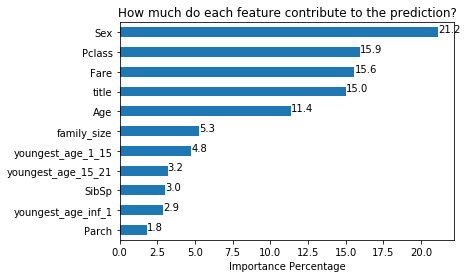

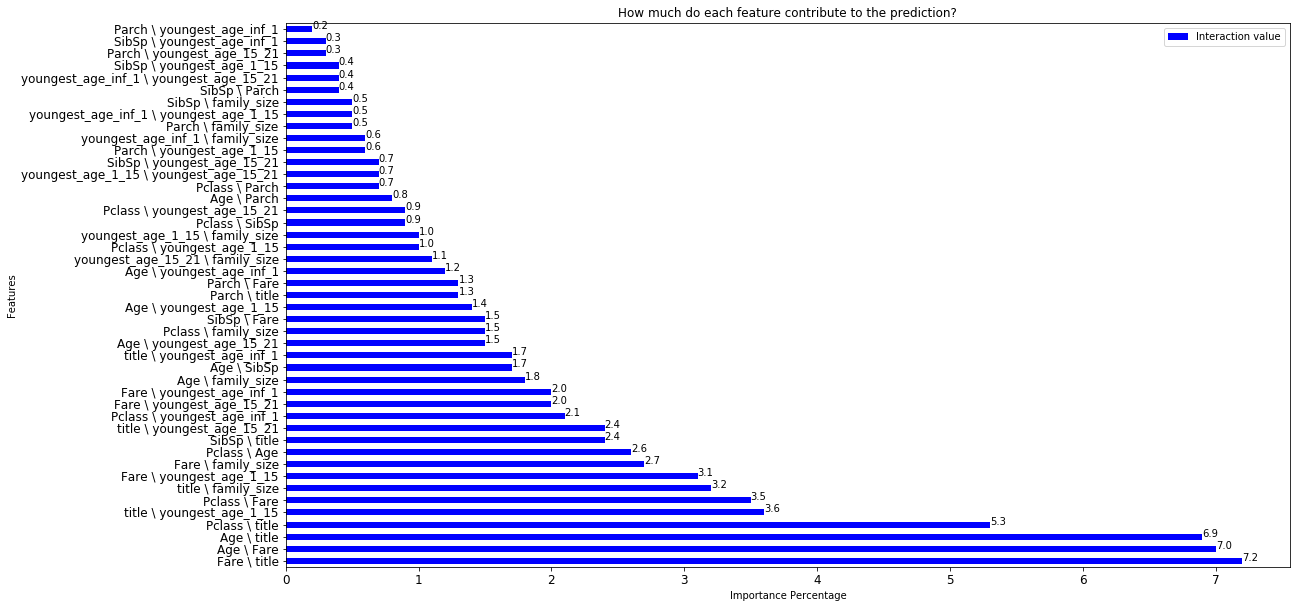

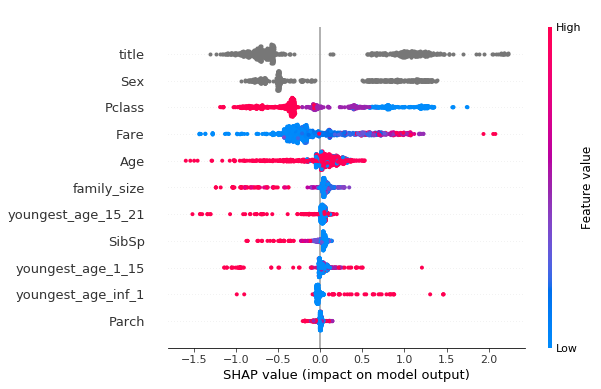

In [11]:
model.inspect_model()

Variable importance seems sensible for every variable. Gender is the most important, followed by two socio-economic features (Pclass, Fare). The family's description features (family size, count of children of age 0-1, 1-15, 15-1) is quite important. Age of the person is also, as expected, important.

We may want to perform additional checks to see if a variable isn't adding noise. For example, title seems to be important, but most of the information it should use from it should already be in "Sex". Are we seing overfitting? The same comment could be made for SibSb and Parch.

Here's without SibSp and Parch:

['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'title', 'youngest_age_inf_1', 'youngest_age_1_15', 'youngest_age_15_21', 'family_size']
cross validation scores with catboost: 
iterations              999.000000
test-Precision-mean       0.822631
test-Precision-std        0.029586
train-Precision-mean      0.989125
train-Precision-std       0.007162
test-Logloss-mean         0.444608
test-Logloss-std          0.064270
train-Logloss-mean        0.121625
train-Logloss-std         0.012501
Name: 999, dtype: float64
parameters: {'eval_metric': 'Precision', 'loss_function': 'Logloss'}


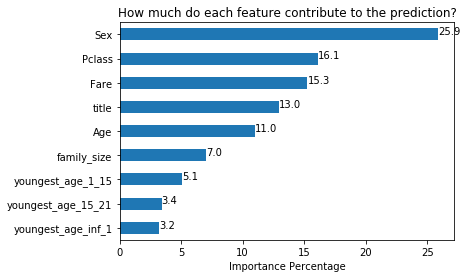

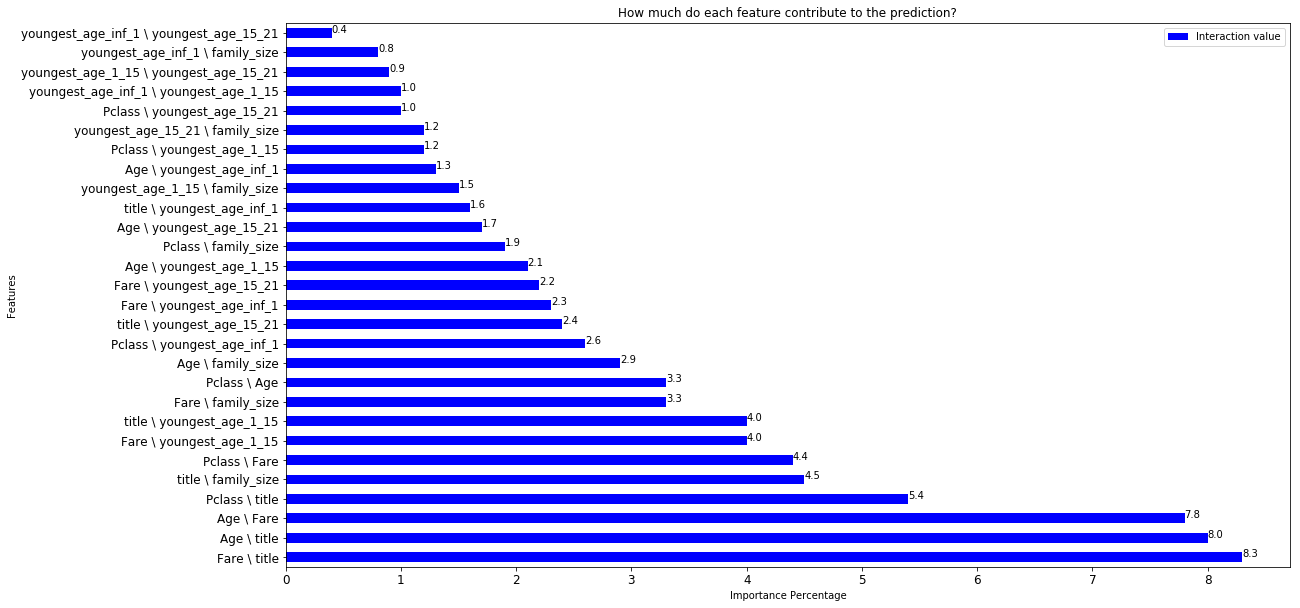

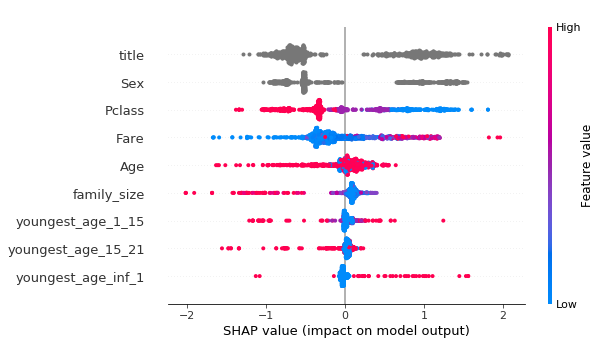

CPU times: user 17.7 s, sys: 4.87 s, total: 22.6 s
Wall time: 1min 9s


In [12]:
%%time
model = CatboostModel() 
model.fit(preprocess(train).fillna(-1000).drop(["Cabin", "Embarked", "Name", "Ticket", "SibSp", "Parch"], axis=1))
pred = model.predict(preprocess(test).fillna(-1000).drop(["Cabin", "Embarked", "Name", "Ticket", "SibSp", "Parch"], axis=1))
pred.to_csv('submission_with_features.csv', index=False)
model.inspect_model()

We do see an increase in test accuracy in the cross validation. Results also improve in the submission to 0.77990, so this quick trick did help us do a sanity check and identify variables that should be dropped.

Taking away title isn't as helpful: there may be some overfitting, but there may also be some useful information. E.g. Miss would indicate a single woman, which could have less chances of embarking a life boat as a woman with a young child. It also could contain information on social ranking. This variable requires extra processing, and for that we would need to know exactly how it is used to generate the predictions. This isn't however the purpose of this experiment, I will leave it for a later one.
### Playing with catboost's parameters

One last thing I would like to see is the influence of tuning the model. I would like to compare the first run with no feature building with added parameter tuning, with the latest run with features built and non useful features dropped.

#### Trial one: using the features and dropping non useful variables
We will set early_stopping_rounds to 20 to avoid overtitting and get a faster compute.

['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'title', 'youngest_age_inf_1', 'youngest_age_1_15', 'youngest_age_15_21', 'family_size']


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


optimal_parameters: {'learning_rate': 0.0001, 'max_depth': 10, 'reg_lambda': 100.0}
optimal score: 0.8969613128630102
updating model with optimal values
['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'title', 'youngest_age_inf_1', 'youngest_age_1_15', 'youngest_age_15_21', 'family_size']
cross validation scores with catboost: 
iterations              100.000000
test-Precision-mean       0.777825
test-Precision-std        0.023778
train-Precision-mean      0.786601
train-Precision-std       0.018917
test-Logloss-mean         0.688740
test-Logloss-std          0.000055
train-Logloss-mean        0.688672
train-Logloss-std         0.000483
Name: 100, dtype: float64
parameters: {'early_stopping_rounds': 100, 'reg_lambda': 100.0, 'max_depth': 10, 'task_type': 'GPU', 'eval_metric': 'Precision', 'loss_function': 'Logloss', 'learning_rate': 0.0001}


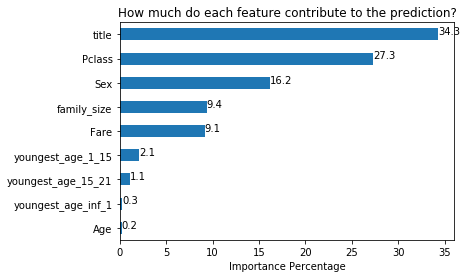

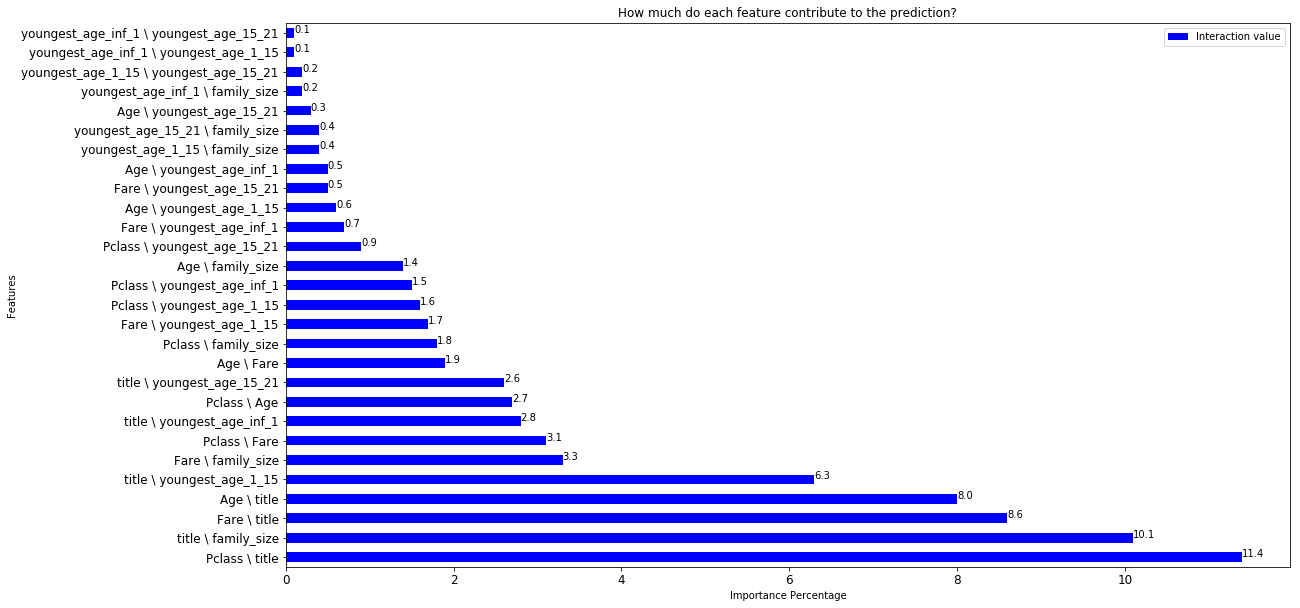

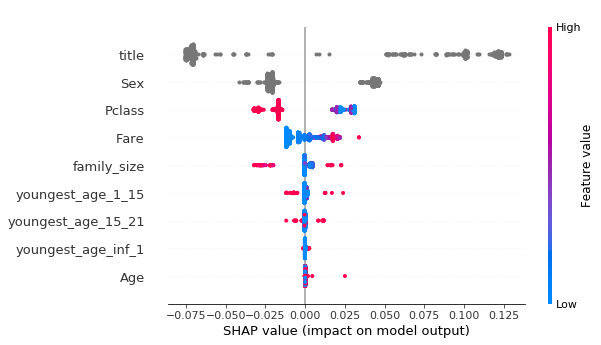

CPU times: user 14min 29s, sys: 6min 29s, total: 20min 59s
Wall time: 18min 28s


In [13]:
%%time
from skopt.space import Real, Integer

param_space = [Real(1e-4, 0.2, prior='log-uniform', name='learning_rate'), 
                Integer(2, 10, name='max_depth'),
                #Real(0.5, 1.0, name='subsample'),
                #Real(0.5, 1.0, name='colsample_bylevel'), 
                #Real(1.0, 16.0, name='scale_pos_weight'), 
                #Real(0.0, 1.0, name='bagging_temperature'), 
                #Integer(1, 20, name='random_strength'), 
                Real(1.0, 100, name='reg_lambda')]

model = CatboostModel(early_stopping_rounds=100,
                     task_type="GPU")  
model.tune_model(preprocess(train).fillna(-1000).drop(["Cabin", "Embarked", "Name", "Ticket", "SibSp", "Parch"], axis=1), 
                 space=param_space,                    
                 stratified=True, 
                 shuffle=True,
                 nfold=3
                 )

model.fit(preprocess(train).fillna(-1000).drop(["Cabin", "Embarked", "Name", "Ticket", "SibSp", "Parch"], axis=1),
          stratified=True, 
          shuffle=True,
          nfold=3
          )
pred = model.predict(preprocess(test).fillna(-1000).drop(["Cabin", "Embarked", "Name", "Ticket", "SibSp", "Parch"], axis=1))
pred.to_csv('submission_with_features_tuned.csv', index=False)
model.inspect_model()

#### Trial two: providing the text feature, no preprocessing and basic model tuning

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
optimal_parameters: {'learning_rate': 3.707964611842831e-05, 'max_depth': 3, 'reg_lambda': 20.718105780711504}
optimal score: 0.8899679141078625
updating model with optimal values
['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
cross validation scores with catboost: 
iterations              100.000000
test-Precision-mean       0.753968
test-Precision-std        0.006873
train-Precision-mean      0.752733
train-Precision-std       0.016407
test-Logloss-mean         0.691324
test-Logloss-std          0.000043
train-Logloss-mean        0.691288
train-Logloss-std         0.000135
Name: 100, dtype: float64
parameters: {'early_stopping_rounds': 100, 'reg_lambda': 20.718105780711504, 'max_depth': 3, 'task_type': 'GPU', 'eval_metric': 'Precision', 'loss_function': 'Logloss', 'learning_rate': 3.707964611842831e-05}


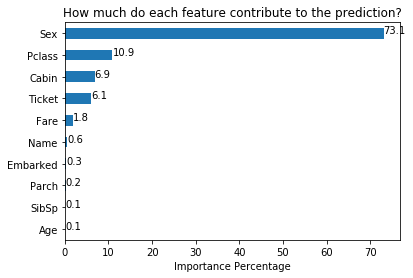

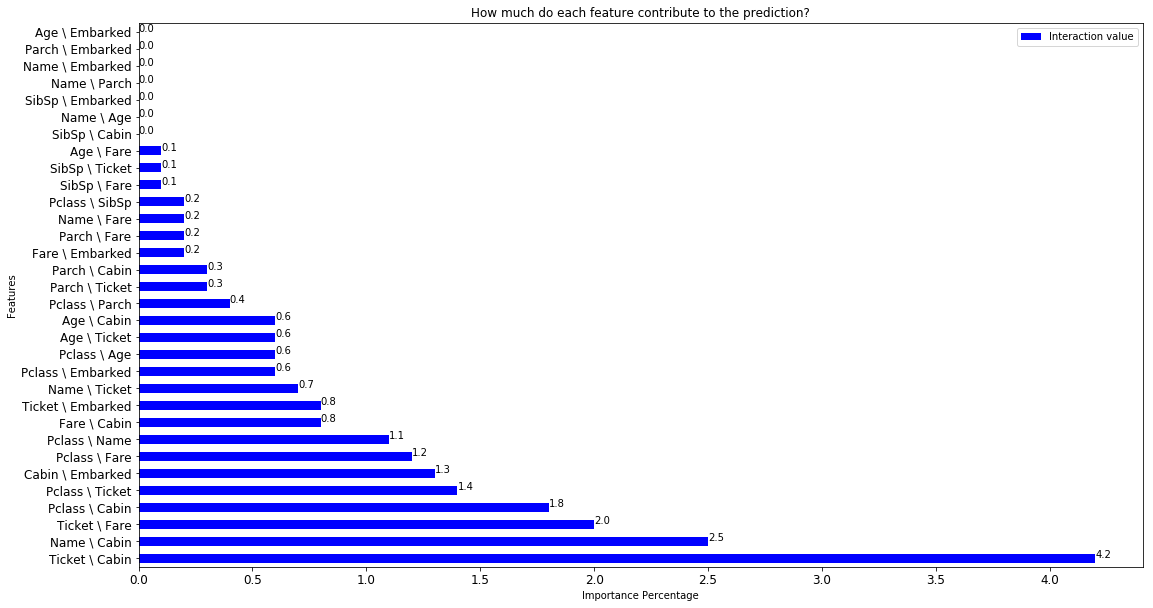

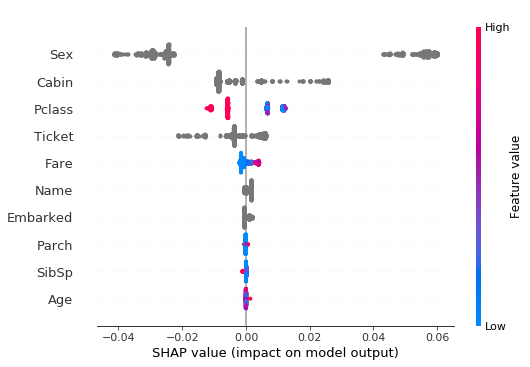

CPU times: user 8min 47s, sys: 3min 32s, total: 12min 20s
Wall time: 10min 35s


In [14]:
%%time
from skopt.space import Real, Integer

param_space = [Real(1e-5, 0.2, prior='log-uniform', name='learning_rate'), 
                Integer(2, 10, name='max_depth'),
                #Real(0.5, 1.0, name='subsample'),
                #Real(0.5, 1.0, name='colsample_bylevel'), 
                #Real(1.0, 16.0, name='scale_pos_weight'), 
                #Real(0.0, 1.0, name='bagging_temperature'), 
                #Integer(1, 20, name='random_strength'), 
                Real(1.0, 100, name='reg_lambda')]

model = CatboostModel(task_type="GPU",
                      early_stopping_rounds=100)

model.tune_model(train, 
                 space=param_space,   
                 text_features="Name",
                 stratified=True, 
                 shuffle=True,
                 nfold=3,
                 n_jobs=1)

model.fit(train)
pred = model.predict(test)
pred.to_csv('submission_tuned.csv', index=False)
model.inspect_model()

#### Without early stopping


['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'title', 'youngest_age_inf_1', 'youngest_age_1_15', 'youngest_age_15_21', 'family_size']


The objective has been evaluated at this point before.


optimal_parameters: {'learning_rate': 0.2, 'max_depth': 6, 'reg_lambda': 100.0}
optimal score: 0.88274101879839
updating model with optimal values
['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'title', 'youngest_age_inf_1', 'youngest_age_1_15', 'youngest_age_15_21', 'family_size']
cross validation scores with catboost: 
iterations              999.000000
test-Precision-mean       0.812975
test-Precision-std        0.018955
train-Precision-mean      0.952839
train-Precision-std       0.008633
test-Logloss-mean         0.433909
test-Logloss-std          0.074573
train-Logloss-mean        0.175220
train-Logloss-std         0.009801
Name: 999, dtype: float64
parameters: {'reg_lambda': 100.0, 'max_depth': 6, 'task_type': 'GPU', 'eval_metric': 'Precision', 'loss_function': 'Logloss', 'learning_rate': 0.2}


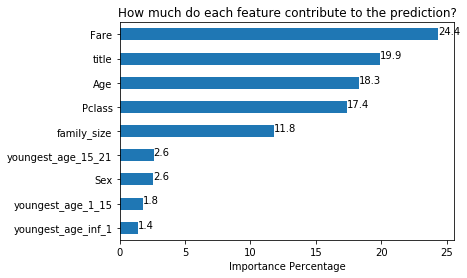

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


The objective has been evaluated at this point before.


optimal_parameters: {'learning_rate': 0.00025472869699346573, 'max_depth': 4, 'reg_lambda': 1.0}
optimal score: 0.8909609735639763
updating model with optimal values
['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
cross validation scores with catboost: 
iterations              999.000000
test-Precision-mean       0.805845
test-Precision-std        0.013064
train-Precision-mean      0.794055
train-Precision-std       0.014047
test-Logloss-mean         0.583615
test-Logloss-std          0.005107
train-Logloss-mean        0.581479
train-Logloss-std         0.007582
Name: 999, dtype: float64
parameters: {'reg_lambda': 1.0, 'max_depth': 4, 'task_type': 'GPU', 'eval_metric': 'Precision', 'loss_function': 'Logloss', 'learning_rate': 0.00025472869699346573}


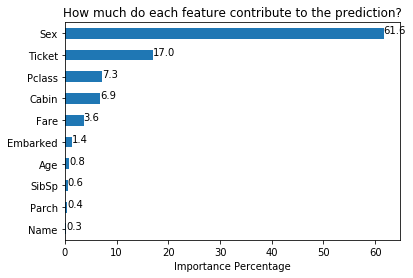

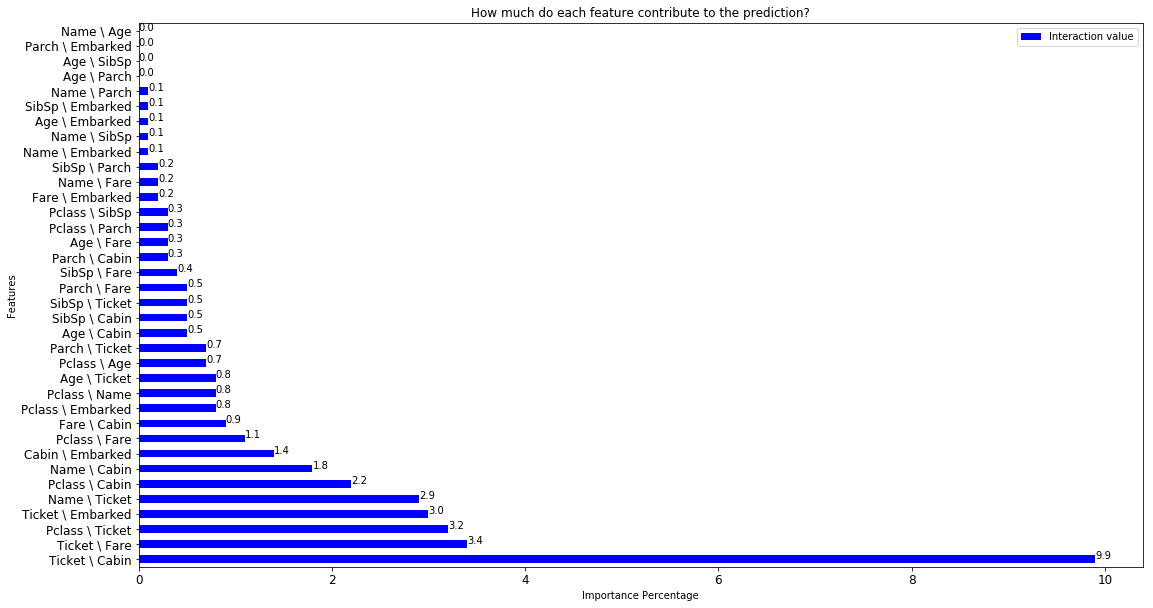

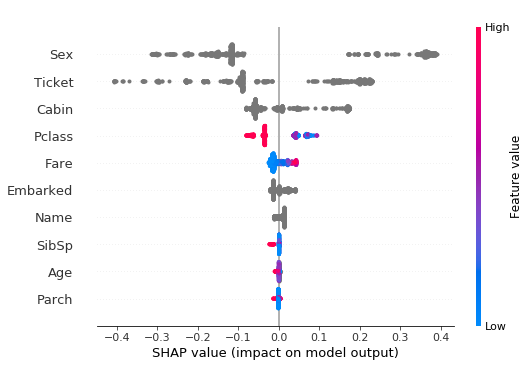

CPU times: user 1h 34min 18s, sys: 46min 14s, total: 2h 20min 32s
Wall time: 2h 7min 52s


In [15]:
%%time
from skopt.space import Real, Integer

param_space = [Real(1e-4, 0.2, prior='log-uniform', name='learning_rate'), 
                Integer(2, 10, name='max_depth'),
                Real(1.0, 100, name='reg_lambda')]

model = CatboostModel(task_type="GPU")  
model.tune_model(preprocess(train).fillna(-1000).drop(["Cabin", "Embarked", "Name", "Ticket", "SibSp", "Parch"], axis=1), 
                 space=param_space,                    
                 stratified=True, 
                 shuffle=True,
                 nfold=3
                 )

model.fit(preprocess(train).fillna(-1000).drop(["Cabin", "Embarked", "Name", "Ticket", "SibSp", "Parch"], axis=1),
          stratified=True, 
          shuffle=True,
          nfold=3
          )
pred = model.predict(preprocess(test).fillna(-1000).drop(["Cabin", "Embarked", "Name", "Ticket", "SibSp", "Parch"], axis=1))
pred.to_csv('submission_with_features_tuned_no_early_stop.csv', index=False)
model.plot_importance()


model = CatboostModel(task_type="GPU")

model.tune_model(train, 
                 space=param_space,   
                 text_features="Name",
                 stratified=True, 
                 shuffle=True,
                 nfold=3,
                 n_jobs=1)

model.fit(train)
pred = model.predict(test)
pred.to_csv('submission_tuned_no_early_stop.csv', index=False)
model.inspect_model()

## Conclusion
It looks like catboost can help fast prototyping thanks to the reduced work in encoding variables. It also is a good thing that new unseen categorical variables do not make the model fail, which means in production if something changes in the input data the modeling pipeline will not fail, which means a fix or model retraining can be done without a sense of absolute urgency.

Catboost also provides useful ways of exploring the features and the model, thanks to feature importance, feature interactions and the integration with SHAP.

Finally, Catboost is quite sensitive to its parameters. The best results were over 0.79 on the submission, but they varied quite a bit. It seems the algorithm needs to be tuned with caution, and I need more experience tuning it. The default parameters provide already a good baseline.

## Sources
The following have been very useful for me to learn how to perform tasks that were new for me:
Catboost documentation: https://catboost.ai/docs/
sklearn hyper parameter optimization: https://scikit-optimize.github.io/stable/auto_examples/hyperparameter-optimization.html
towards data science (excellent!) article on catboost (recommend the read): https://towardsdatascience.com/https-medium-com-talperetz24-mastering-the-new-generation-of-gradient-boosting-db04062a7ea2

Thanks to Kaggle for allowing access to computing resources and a GPU.